- This notebook is for training the model for predicting the column "Appliances" while it is considered as categorical data.
- GitHub Repo: https://github.com/wjx2018neu/71238---ALY-6140---03

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rn
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import load_model
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
# prepare the functions for evaluating the model
def mse(ar1, ar2):
    return ((ar1 - ar2) ** 2).mean()

def rmse(ar1, ar2):
    return np.sqrt(mse(ar1, ar2))

In [3]:
# make the results reproducible
os.environ["PYTHONHASHSEED"] = '0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [4]:
# loading and preprocessing data
energydata_complete = pd.read_csv("energydata_complete.csv").iloc[:, 1:]

energydata_complete = energydata_complete.drop(['lights'], axis=1)

Y = energydata_complete.iloc[:, 0].values

labelencoder_Y_1 = LabelEncoder()
Y_labled = labelencoder_Y_1.fit_transform(Y)

onehotencoder = OneHotEncoder(categorical_features = [0])
Y_onehot = onehotencoder.fit_transform(Y_labled.reshape(Y_labled.shape[0], 1)).toarray()
print(Y_onehot)

Y_columnnames = []
for i in range(Y_onehot.shape[1]):
    if i < 10:
        Y_columnnames.append("Y1_0{0}".format(i))
    else:
        Y_columnnames.append("Y1_{0}".format(i))

Y_onehot = pd.DataFrame(Y_onehot, columns = Y_columnnames)

sc = MinMaxScaler(feature_range = (0, 1))
variables_scaled = pd.DataFrame(sc.fit_transform(energydata_complete.iloc[:, 1:]), columns = list(energydata_complete.iloc[:, 1:].columns))
print(variables_scaled.head())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
        T1      RH_1        T2      RH_2        T3      RH_3        T4  \
0  0.32735  0.566187  0.225345  0.684038  0.215188  0.746066  0.351351   
1  0.32735  0.541326  0.225345  0.682140  0.215188  0.748871  0.351351   
2  0.32735  0.530502  0.225345  0.679445  0.215188  0.755569  0.344745   
3  0.32735  0.524080  0.225345  0.678414  0.215188  0.758685  0.341441   
4  0.32735  0.531419  0.225345  0.676727  0.215188  0.758685  0.341441   

       RH_4        T5      RH_5    ...           T9      RH_9     T_out  \
0  0.764262  0.175506  0.381691    ...     0.223032  0.677290  0.372990   
1  0.782437  0.175506  0.381691    ...     0.226500  0.678532  0.369239   
2  0.778062  0.175506  0.380037    ...     0.219563  0.676049  0.365488   
3  0.770949  0.175506  0.380037    ...     0.219563  0.671909  0.361736   
4  0.762697  0.178691  0

d:\programfilesnospace\miniconda3\envs\py365-tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
d:\programfilesnospace\miniconda3\envs\py365-tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [5]:
# separate the data into training set and testing set
X_train_scaled = variables_scaled.iloc[:round(np.shape(variables_scaled)[0] * 0.8), :]
Y_train_encoded = Y_onehot.iloc[:round(np.shape(Y_onehot)[0] * 0.8), :]

X_test_scaled = variables_scaled.iloc[round(np.shape(variables_scaled)[0] * 0.8):, :]
Y_test_encoded = Y_onehot.iloc[round(np.shape(Y_onehot)[0] * 0.8):, :]

X_train_scaled = np.reshape(X_train_scaled.values, (X_train_scaled.values.shape[0], X_train_scaled.values.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled.values, (X_test_scaled.values.shape[0], X_test_scaled.values.shape[1], 1))

In [6]:
# Initialising the RNN
layers = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layers.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
layers.add(Dropout(0.2))

layers.add(Flatten())

# Adding the output layer
layers.add(Dense(Y_train_encoded.shape[1], activation='softmax'))

layers.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/100
15788/15788 [==============================] - 2s 125us/step - loss: 3.0748 - acc: 0.1956
Epoch 2/100
15788/15788 [==============================] - 1s 82us/step - loss: 2.8575 - acc: 0.2183
Epoch 3/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.8466 - acc: 0.2162
Epoch 4/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.8421 - acc: 0.2180
Epoch 5/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.8361 - acc: 0.2198
Epoch 6/100
15788/15788 [==============================] - 1s 81us/step - loss: 2.8279 - acc: 0.2195
Epoch 7/100
15788/15788 [==============================] - 1s 81us/step - loss: 2.8225 - acc: 0.2198
Epoch 8/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.8127 - acc: 0.2207
Epoch 9/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.7986 - acc: 0.2211
Epoch 10/100
15788/15788 [==============================] - 1s 81us/step - loss: 2.7825 - 

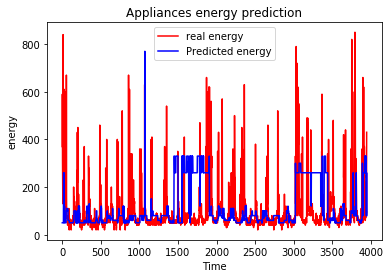

In [7]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers1_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers1_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/100
15788/15788 [==============================] - 1s 82us/step - loss: 2.3707 - acc: 0.2769
Epoch 2/100
15788/15788 [==============================] - 1s 81us/step - loss: 2.3702 - acc: 0.2759
Epoch 3/100
15788/15788 [==============================] - 1s 90us/step - loss: 2.3635 - acc: 0.2807
Epoch 4/100
15788/15788 [==============================] - 1s 87us/step - loss: 2.3609 - acc: 0.2843
Epoch 5/100
15788/15788 [==============================] - 1s 94us/step - loss: 2.3567 - acc: 0.2798
Epoch 6/100
15788/15788 [==============================] - 1s 86us/step - loss: 2.3498 - acc: 0.2814
Epoch 7/100
15788/15788 [==============================] - 1s 87us/step - loss: 2.3478 - acc: 0.2845
Epoch 8/100
15788/15788 [==============================] - 1s 88us/step - loss: 2.3424 - acc: 0.2845
Epoch 9/100
15788/15788 [==============================] - 1s 81us/step - loss: 2.3417 - acc: 0.2809
Epoch 10/100
15788/15788 [==============================] - 1s 81us/step - loss: 2.3368 - a

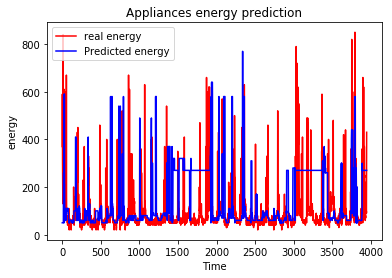

In [8]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers1_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers1_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/100
15788/15788 [==============================] - 2s 122us/step - loss: 2.0275 - acc: 0.3273
Epoch 2/100
15788/15788 [==============================] - 1s 86us/step - loss: 2.0137 - acc: 0.3324
Epoch 3/100
15788/15788 [==============================] - 1s 92us/step - loss: 2.0100 - acc: 0.3341
Epoch 4/100
15788/15788 [==============================] - 1s 86us/step - loss: 2.0094 - acc: 0.3334
Epoch 5/100
15788/15788 [==============================] - 1s 92us/step - loss: 2.0106 - acc: 0.3328
Epoch 6/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.0023 - acc: 0.3353
Epoch 7/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.9940 - acc: 0.3396
Epoch 8/100
15788/15788 [==============================] - 1s 80us/step - loss: 2.0016 - acc: 0.3368
Epoch 9/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.9981 - acc: 0.3341
Epoch 10/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.9897 - 

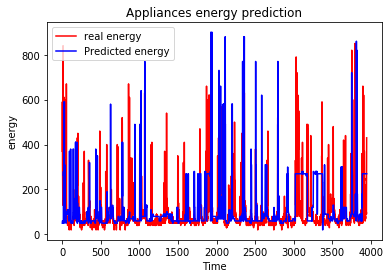

In [9]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers1_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers1_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/100
15788/15788 [==============================] - 2s 108us/step - loss: 1.8100 - acc: 0.3700
Epoch 2/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.8022 - acc: 0.3758
Epoch 3/100
15788/15788 [==============================] - 1s 80us/step - loss: 1.8009 - acc: 0.3726
Epoch 4/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.7957 - acc: 0.3755
Epoch 5/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.8067 - acc: 0.3706
Epoch 6/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.7983 - acc: 0.3738
Epoch 7/100
15788/15788 [==============================] - 1s 82us/step - loss: 1.7910 - acc: 0.3751
Epoch 8/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.7997 - acc: 0.3722
Epoch 9/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.8000 - acc: 0.3719
Epoch 10/100
15788/15788 [==============================] - 1s 81us/step - loss: 1.7844 - 

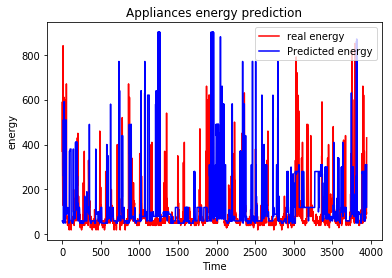

In [10]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 100, batch_size = 512)

# layers.save('layers1_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers1_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

- The result is not ideal, moreover, the accuracy is below 20% and the mean squared error is more than 10000. After 4 iterations it’s still underfitting. So, we conclude this model is not suitable for this scenario.